In [3]:
from qiskit import QuantumCircuit
from qiskit_aer import AerProvider
from qiskit.circuit import Clbit, ClassicalRegister
from qiskit_experiments.library import StateTomography
from qiskit.visualization import array_to_latex, plot_state_city
from qiskit.quantum_info import DensityMatrix, Pauli
from itertools import repeat, product
from operator import add, mul
import numpy as np
from qiskit.primitives import Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from math import cos, sin, sqrt, pi

# Stoke's parameters tomography


In [28]:
# This is an attempt to create a function that does the required simulations for
# obtaining a tomography of n qubits
def n_tomography(qc: QuantumCircuit, meas_qbits: list[int]) -> DensityMatrix:
    basis = [1, 2, 3]
    n_qbits = len(meas_qbits)
    p = np.zeros(list(repeat(6, n_qbits)))
    s = np.zeros(list(repeat(4, n_qbits)))
    s[0, 0] = 1
    for measurement in product(*repeat(basis, n_qbits)):
        print(f"Performing measurement {measurement}")
        sampler = Sampler()
        _qc = qc.copy()
        _qc.name = "".join("".join(str(i) for i in measurement))
        for i in range(0, n_qbits):
            m = measurement[i]
            if m == 1:
                _qc.h(meas_qbits[i])
            elif m == 2:
                _qc.sdg(meas_qbits[i])
                _qc.h(meas_qbits[i])
        
        cl_reg = ClassicalRegister(bits=[Clbit() for _ in range(n_qbits)])
        _qc.add_register(cl_reg)
        _qc.measure(meas_qbits, list(range(0, n_qbits)))   

        job = sampler.run(_qc)
        result = job.result()

        # print(f"Result: {result.quasi_dists[0]}")

        i = 0
        start = (np.array(measurement) - 1) * 2
        for delta in product(*repeat([0, 1], n_qbits)):
            res_obj = result.quasi_dists[0]
            prob = res_obj[i] if i in res_obj else 0
            pos = start + np.array(delta)
            p[*pos] = prob

            if sum(pos) % 2 == 0:
                s[*measurement] += prob
            else:
                s[*measurement] -= prob

            i += 1
    # print(p)
    for i in basis:
        j = 0
        start = (np.array([i, i]) - 1) * 2
        for delta in product(*repeat([0, 1], n_qbits)):
            pos = start + np.array(delta)
            if j % 2 == 0:
                s[0, i] += p[*pos]
            else:
                s[0, i] -= p[*pos]

            if j < (2 ** n_qbits) / 2:
                s[i, 0] += p[*pos]
            else:
                s[i, 0] -= p[*pos]

            j += 1
    # print(p)
    # print(s)

    p_map = ["I", "X", "Y", "Z"]
    density = np.zeros((2**n_qbits, 2**n_qbits), dtype=np.complex128)
    for measurement in product(*repeat([0] + basis, n_qbits)): 
        key = "".join([p_map[i] for i in measurement])
        pauli = Pauli(key).to_matrix()
        density += s[*measurement] * pauli
    density /= (2 ** n_qbits)

    return DensityMatrix(density)

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)

array_to_latex(n_tomography(qc, [0, 1]).data)


Performing measurement (1, 1)
Performing measurement (1, 2)
Performing measurement (1, 3)
Performing measurement (2, 1)
Performing measurement (2, 2)
Performing measurement (2, 3)
Performing measurement (3, 1)
Performing measurement (3, 2)
Performing measurement (3, 3)


<IPython.core.display.Latex object>

# Maximum likelihood

The following code block contains functions just to test that we are building the correct density matrix from the probabilities obtained from the quantum computer.

In [26]:
from common.qiskit_run import resolve_stokes, create_density_matrix

def theory_dm(p, t):
    th = t / 2
    return np.matrix(
        [
            [p, 0, 0, 0],
            [0, (1 - p) * cos(th) ** 2, (1 - p) * cos(th) * sin(th), 0],
            [0, (1 - p) * cos(th) * sin(th), (1 - p) * sin(th) ** 2, 0],
            [0, 0, 0, 0],
        ]
    )


h = np.matrix([1, 0]).T
v = np.matrix([0, 1]).T
bs = {
    "h": h,
    "v": v,
    "d": (h + v) / sqrt(2),
    "a": (h - v) / sqrt(2),
    "r": (h + (1j) * v) / sqrt(2),
    "l": (h - (1j) * v) / sqrt(2),
}


def res_prob(dm: np.array) -> np.array:
    com = (("d", "a"), ("r", "l"), ("h", "v"))

    res = {}
    for k0, v0 in bs.items():
        for k1, v1 in bs.items():
            res[k0 + k1] = (np.kron(v0, v1).H * dm * np.kron(v0, v1)).item()

    return [
        [res[p10 + p11].real for (p10, p11) in product(p00, p01)]
        for (p00, p01) in product(com, com)
    ]

def res_stokes(dm: np.array) -> np.array:
    stokes = np.zeros((4, 4), dtype=np.complex128)
    p_map = ["I", "X", "Y", "Z"]
    for i in [0, 1, 2, 3]:
        for j in [0, 1, 2, 3]:
            pauli = Pauli("".join([p_map[i] for i in [i, j]])).to_matrix()
            stokes[i, j] = (dm * pauli).trace().item()

    return stokes


def res_jobs(probs):
    res = []
    for i in range(1, 4):
        for j in range(1, 4):
            p = probs[(i - 1) * 3 + j - 1]
            res.append(
                {
                    "s": [i, j],
                    "id": "test",
                    "result": {"0": p[0], "1": p[2], "2": p[1], "3": p[3]},
                }
            )
    return res

# array_to_latex(theory_dm(0.5, 0.62))
# sk = resolve_stokes(jobs)
# exp_dm = create_density_matrix(sk)
# array_to_latex(sk)
dm = theory_dm(0.75, 0*pi)
jobs = res_jobs(res_prob(dm))
jobs

[{'s': [1, 1],
  'id': 'test',
  'result': {'0': 0.2499999999999999,
   '1': 0.2499999999999999,
   '2': 0.2499999999999999,
   '3': 0.2499999999999999}},
 {'s': [1, 2],
  'id': 'test',
  'result': {'0': 0.2499999999999999,
   '1': 0.2499999999999999,
   '2': 0.2499999999999999,
   '3': 0.2499999999999999}},
 {'s': [1, 3],
  'id': 'test',
  'result': {'0': 0.37499999999999994,
   '1': 0.37499999999999994,
   '2': 0.12499999999999997,
   '3': 0.12499999999999997}},
 {'s': [2, 1],
  'id': 'test',
  'result': {'0': 0.2499999999999999,
   '1': 0.2499999999999999,
   '2': 0.2499999999999999,
   '3': 0.2499999999999999}},
 {'s': [2, 2],
  'id': 'test',
  'result': {'0': 0.2499999999999999,
   '1': 0.2499999999999999,
   '2': 0.2499999999999999,
   '3': 0.2499999999999999}},
 {'s': [2, 3],
  'id': 'test',
  'result': {'0': 0.37499999999999994,
   '1': 0.37499999999999994,
   '2': 0.12499999999999997,
   '3': 0.12499999999999997}},
 {'s': [3, 1],
  'id': 'test',
  'result': {'0': 0.49999999999

## Theory and experiment comparison

In [123]:
from common.qiskit_run import load_job_data

load_job_data("./quantum/data/amplitude_damping.json")

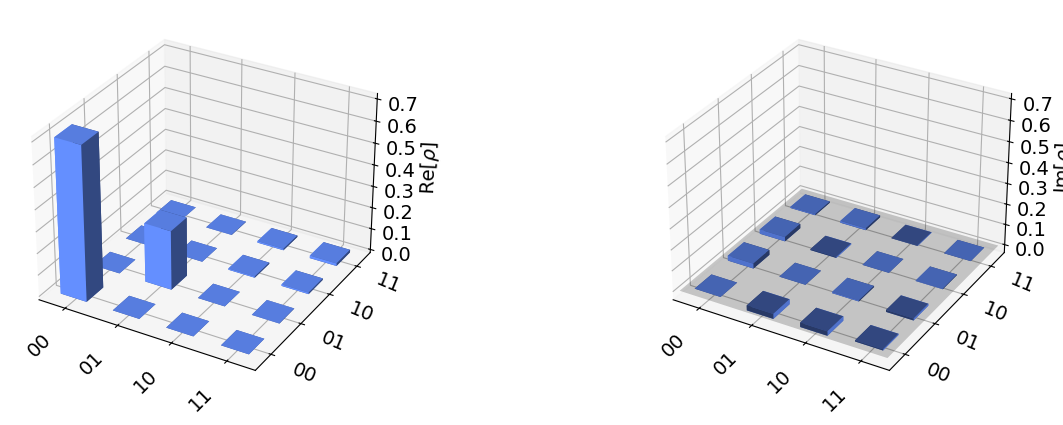

In [38]:
from common.qiskit_run import jobs_to_dm
from qiskit.visualization import array_to_latex, plot_state_city
from qiskit.quantum_info import concurrence
from json import load

with open("./quantum/data/amplitude_damping.json") as f:
    exp = load(f)

e = exp[5]
p = e["p"]
t = e["t"]
dm = jobs_to_dm(e["jobs"])
plot_state_city(dm)

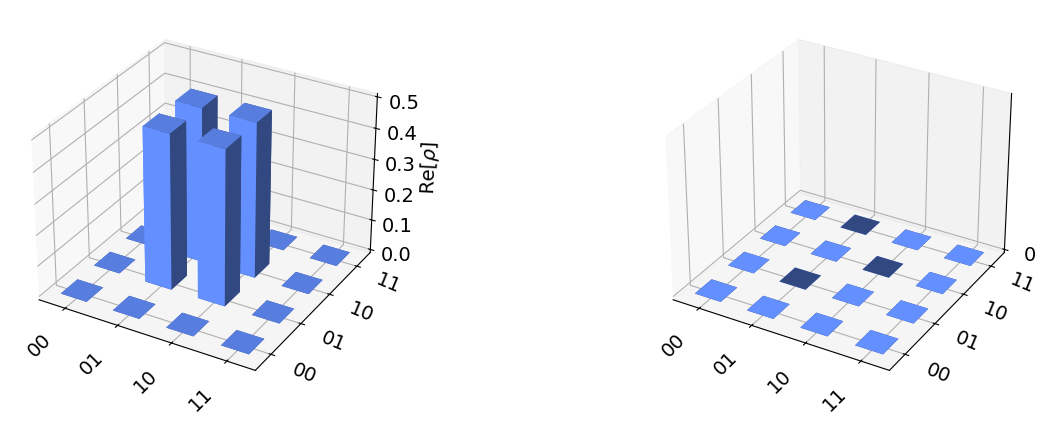

In [76]:
dm = theory_dm(0, pi * 5 / 10)
plot_state_city(dm)